# Setup

In [1]:
!pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import gc
import math
import random
from glob import glob
from collections import defaultdict, Counter
from typing import List, Dict
import joblib
import pickle

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GroupKFold

## constants

In [3]:
EXP_NAME = "exp117"
DIR = "/gdrive/MyDrive/amazon_kdd_2023/"
K_FOLDS = 3
SEED = 42
LOCALES = ["UK", "JP", "DE"]

# This parameter controls to which end item the candidate is tied. 
# For example, if [1,2], candidates are generated from the last item and second last item in each session.
LAST_NS = [1, 2, 3] 

In [4]:
# リポジトリ一覧にgcsfuseのものを追加
!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

# インストール
!apt-get update
!apt-get install gcsfuse

# マウント用のディレクトリを準備
!mkdir -p /content/gcs

# バケットをディレクトリにマウント
!gcsfuse kddcup2023_2 /content/gcs

deb http://packages.cloud.google.com/apt gcsfuse-focal main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  45844      0 --:--:-- --:--:-- --:--:-- 45844
OK
Hit:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://archive.ubuntu.com/ubuntu focal-backport

In [5]:
%env DATA_ROOT /content/data

env: DATA_ROOT=/content/data


In [6]:
%env EXP_NAME exp115

env: EXP_NAME=exp115


In [7]:
!mkdir -p ${DATA_ROOT} && \
    cp /content/gcs/train/task1/train_${EXP_NAME}_0.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}_0.zip

Archive:  train_exp115_0.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)


In [8]:
!cp /content/gcs/train/task1/train_${EXP_NAME}_1.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}_1.zip

Archive:  train_exp115_1.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)


In [9]:
!cp /content/gcs/train/task1/train_${EXP_NAME}_2.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}_2.zip

Archive:  train_exp115_2.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)


In [10]:
!cp /content/gcs/train/task1/train_${EXP_NAME}_3.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}_3.zip

Archive:  train_exp115_3.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)


In [11]:
!cp /content/gcs/train/task1/train_${EXP_NAME}_4.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}_4.zip

Archive:  train_exp115_4.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)


In [12]:
!cp /content/gcs/train/task1/train_${EXP_NAME}_5.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}_5.zip

Archive:  train_exp115_5.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)


In [13]:
!cp /content/gcs/train/task1/train_${EXP_NAME}_6.zip ${DATA_ROOT} && \
    cd ${DATA_ROOT} && \
    unzip -n train_${EXP_NAME}_6.zip

Archive:  train_exp115_6.zip
Created by ZIP Extractor v4.50 (https://zipextractor.app)


In [14]:
PARAMS = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "boosting": "gbdt",
    "seed": SEED,
    "num_leaves": 32,
    "max_depth": 7,
    "learning_rate": 0.1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 5,
    "min_data_in_leaf": 30,
    "eval_at": [20],
    "lambdarank_truncation_level" : 40,
    "deterministic":True,
}

In [15]:
USE_FEATURES = [
    # === candidate features ===
    "co_visit_weight_last1", "consective_1_weight_last1", "consective_3_weight_last1", "consective_5_weight_last1", "similarity_score_last1", "bert_distance_last1", "lift_last1", "prone_distance_last1",
    "co_visit_weight_last2", "consective_1_weight_last2", "consective_3_weight_last2", "consective_5_weight_last2", "similarity_score_last2", "bert_distance_last2", "lift_last2", "prone_distance_last2",
    "co_visit_weight_last3", "consective_1_weight_last3", "consective_3_weight_last3", "consective_5_weight_last3", "similarity_score_last3", "bert_distance_last3", "lift_last3", "prone_distance_last3",
    "imf_score", "bpr_score",
    "co_visit_rank_last1", "consective_1_rank_last1", "consective_3_rank_last1", "consective_5_rank_last1", "similarity_rank_last1", "bert_rank_last1", "lift_rank_last1", "prone_rank_last1",
    "co_visit_rank_last2", "consective_1_rank_last2", "consective_3_rank_last2", "consective_5_rank_last2", "similarity_rank_last2", "bert_rank_last2", "lift_rank_last2", "prone_rank_last2",
    "co_visit_rank_last3", "consective_1_rank_last3", "consective_3_rank_last3", "consective_5_rank_last3", "similarity_rank_last3", "bert_rank_last3", "lift_rank_last3", "prone_rank_last3",
    "imf_rank", "bpr_rank",
    # === session features ===
    "S_session_length",
    "S_nunique_brand",
    "S_ratio_unique_brand",
    "S_nunique_item",
    "S_ratio_repurchase",
    "S_locale",
    "S_mean_price", "S_max_price", "S_min_price", "S_std_price", "S_total_amount",
    "S_color_not_null_count", "S_size_not_null_count", "S_model_not_null_count", "S_material_not_null_count", "S_author_not_null_count",
    "S_last_item_price",
    # === product features ===
    "P_price",
    "P_purchase_count", "P_purchase_count_global",
    "P_total_amount",
    "P_brand_purchase_count", "P_brand_purchase_count_global",
    "P_brand_mean_price", "P_brand_max_price", "P_brand_min_price", "P_brand_std_price", "P_total_brand_amount",
    "P_price_diff_to_avg_brand_price",
    "P_n_unique_locale",
    "P_is_color_null", "P_is_size_null", "P_is_model_null", "P_is_material_null", "P_is_author_null",
    "P_purchase_count_ratio_to_locale", "P_purchase_amount_ratio_to_locale", "P_purchase_count_ratio_to_brand", "P_purchase_amount_ratio_to_brand",
    # === session * product features ===
    "SP_price_diff_to_mean_price", "SP_price_diff_to_min_price", "SP_price_diff_to_max_price", "SP_price_diff_to_last_price",
    "SP_brand_price_diff_to_mean_price", "SP_brand_price_diff_to_min_price", "SP_brand_price_diff_to_max_price", "SP_brand_price_diff_to_last_price",
    "SP_same_brand_last1", "SP_same_brand_last2", "SP_same_brand_last3",
    "SP_same_color_last1", "SP_same_color_last2", "SP_same_color_last3",
    "SP_same_size_last1", "SP_same_size_last2", "SP_same_size_last3",
    "SP_same_model_last1", "SP_same_model_last2", "SP_same_model_last3",
    "SP_same_material_last1", "SP_same_material_last2", "SP_same_material_last3",
    "SP_same_author_last1", "SP_same_author_last2", "SP_same_author_last3",
    "SP_same_brand_sum", "SP_same_color_sum", "SP_same_size_sum", "SP_same_model_sum", "SP_same_material_sum", "SP_same_author_sum",
    # === similality features ===
    "imf_similarity", "bpr_similarity",
    "graph_emb_similarity_last1", "graph_emb_similarity_last2", "graph_emb_similarity_last3", 
    "i2v_similarity_last1", "i2v_similarity_last2", "i2v_similarity_last3", 
]

## functions

In [16]:
# functions for model training, prediction and evaluation

def train_lgb_model(train:pd.DataFrame) -> np.array:
    feat_imp = np.zeros((len(USE_FEATURES),))
    gkf = GroupKFold(n_splits=K_FOLDS)
    for fold, (train_idx, val_idx) in enumerate(gkf.split(train, train["label"], groups=train["session_id"])):
        print(f'Fold {fold+1}')

        # Split data into train and validation sets
        train_tmp = train.iloc[train_idx].copy()
        valid_tmp = train.iloc[val_idx].copy()
        train_tmp.sort_values("session_id", inplace=True)
        valid_tmp.sort_values("session_id", inplace=True)
        train_baskets = train_tmp.groupby("session_id")["candidate_item"].count().values
        valid_baskets = valid_tmp.groupby("session_id")["candidate_item"].count().values
        X_train, y_train = train_tmp[USE_FEATURES], train_tmp["label"]
        X_val, y_val = valid_tmp[USE_FEATURES], valid_tmp["label"]

        # Create LightGBM dataset
        lgb_train = lgb.Dataset(X_train, y_train, group=train_baskets)
        lgb_val = lgb.Dataset(X_val, y_val, group=valid_baskets, reference=lgb_train)

        del train_tmp, valid_tmp, X_train, y_train, train_baskets, X_val, y_val, valid_baskets
        gc.collect()

        # Train LightGBM model
        model = lgb.train(PARAMS,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=[lgb_train, lgb_val],
                        callbacks=[
                            lgb.early_stopping(stopping_rounds=50),
                            lgb.log_evaluation(100),
                        ]
                )
        
        # Save LightGBM model
        joblib.dump(model, f'/content/gcs/model/task1/{EXP_NAME}_{fold+1}.pkl')

        # Add feature importance scores
        feat_imp += model.feature_importance(importance_type="gain")

    return feat_imp

## fix seed

In [17]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
seed_everything(SEED)

# Train

## train model

In [18]:
files = glob(f"/content/data/train_chunk_exp115_*")
dfs = []
for f in tqdm(files):
    dfs.append(pd.read_parquet(f))
train = pd.concat(dfs)
del dfs; gc.collect()

100%|██████████| 66/66 [01:56<00:00,  1.76s/it]


30

In [19]:
train = train[["session_id", "candidate_item", "label"] + USE_FEATURES]

In [20]:
train.head()

,session_id,candidate_item,label,co_visit_weight_last1,consective_1_weight_last1,consective_3_weight_last1,consective_5_weight_last1,similarity_score_last1,bert_distance_last1,lift_last1,...,SP_same_material_sum,SP_same_author_sum,imf_similarity,bpr_similarity,graph_emb_similarity_last1,graph_emb_similarity_last2,graph_emb_similarity_last3,i2v_similarity_last1,i2v_similarity_last2,i2v_similarity_last3
0,train_1111417,B084QJGSVH,1,3.95,1,2,4,0.705215,0.202256,0.242190,...,0,1,0.033607,0.0,0.639501,0.342910,-1.000000,0.834130,0.859668,-1.000000
1,train_1111418,B08NY8NLGS,1,0.00,0,0,0,0.677728,0.140590,0.000000,...,0,0,0.047032,0.0,0.913188,0.909147,0.913188,0.915032,0.910090,0.915032
2,train_1111419,B09VXJ3V1R,1,0.65,0,0,0,0.377794,0.245923,0.017931,...,0,0,0.170699,0.0,0.709090,0.706344,0.722743,0.789686,0.774387,0.793378
3,train_1111420,B07GH48D5P,1,3.00,1,1,1,0.983818,0.000000,0.369274,...,3,0,0.253944,0.0,0.930691,0.881341,0.840828,0.982889,0.918730,0.930656
4,train_1111422,B08WK59CM6,1,0.00,0,0,0,0.000000,-1.000000,0.000000,...,0,0,0.037218,0.0,0.075622,0.783394,-1.000000,0.877571,0.891324,-1.000000


Fold 1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 8.214548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18062
[LightGBM] [Info] Number of data points in the train set: 81777256, number of used features: 130
Training until validation scores don't improve for 50 rounds
[100]	training's ndcg@20: 0.780193	valid_1's ndcg@20: 0.780545
[200]	training's ndcg@20: 0.783865	valid_1's ndcg@20: 0.783546
[300]	training's ndcg@20: 0.785827	valid_1's ndcg@20: 0.784849
[400]	training's ndcg@20: 0.787152	valid_1's ndcg@20: 0.785564
[500]	training's ndcg@20: 0.788283	valid_1's ndcg@20: 0.785989
[600]	training's ndcg@20: 0.789325	valid_1's ndcg@20: 0.786312
[700]	training's ndcg@20: 0.790238	valid_1's ndcg@20: 0.786515
[800]	training's ndcg@20: 0.791157	valid_1's ndcg@20: 0.786732
[900]	training's ndcg@20: 0.791985	valid_1's ndcg@20: 0.7869
[1000]

[Text(0.5, 1.0, 'Feature Importance TOP25')]

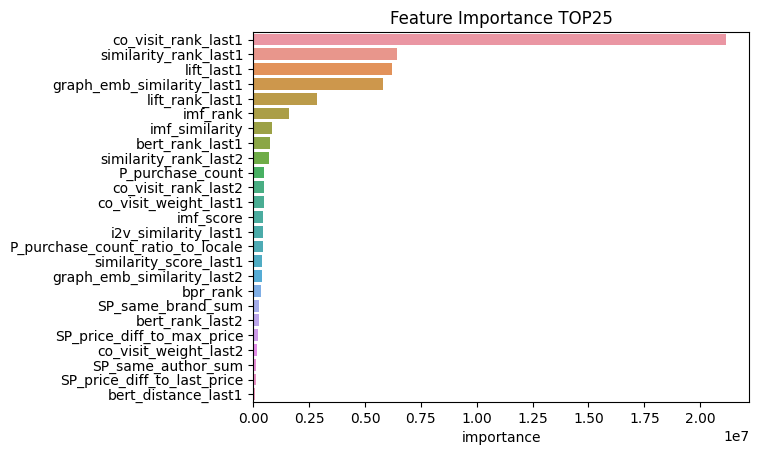

In [21]:
%%time
# train lgbm model
feat_imp = train_lgb_model(train)

# visualize feature importances
fi_df = pd.DataFrame(index=USE_FEATURES)
fi_df["importance"] = feat_imp / K_FOLDS
fi_df = fi_df.sort_values(by="importance", ascending=False).head(25)
sns.barplot(x="importance", y=fi_df.index, data=fi_df).set(title="Feature Importance TOP25")